#### Initial settings

Code written by Maxim Grinin 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def quant(y_true, y_pred, q = 0.25):
    # q - quantile = [0.25, 0.5, 0.75]
    err = (1 / len(y_true)) * sum(y_true - y_pred)
    return np.maximum(q * err, (q - 1) * err)

sns.set_theme(style='whitegrid')

## Data

The data represents the historical revenue of one of the Prisma stores in St. Petersburg

In [3]:
excel = pd.read_excel('data.xlsx', parse_dates = [0])
excel.index = excel['Date']
data = excel[(excel['Date'] > '2015-12')&(excel['Date'] < '2020')]

train = data[(data['Date']>='2016') & (data['Date']<'2018')] # train set: jan 2016 - dec 2017
valid = data[(data['Date']>='2018') & (data['Date']<'2019')] # validation set: 2018
test = data[(data['Date']>='2019') & (data['Date']<'2020')] # Test set: 2019

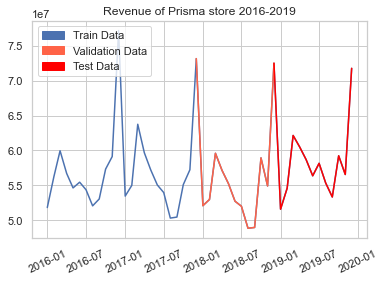

In [4]:
plt.plot(data['Date'], data['Revenue'])

plt.plot(data[(data['Date']>='2017-12') & (data['Date']<'2019')]['Date'], 
         data[(data['Date']>='2017-12') & (data['Date']<'2019')]['Revenue'], 
         color='tomato')

plt.plot(data[(data['Date']>='2018-12') & (data['Date']<'2020')]['Date'], 
         data[(data['Date']>='2018-12') & (data['Date']<'2020')]['Revenue'], 
         color='red')

b_patch = mpatches.Patch(color='C0', label='Train Data')
t_patch = mpatches.Patch(color='tomato', label='Validation Data')
r_patch = mpatches.Patch(color='red', label='Test Data')

plt.legend(handles=[b_patch, t_patch, r_patch])
plt.xticks(rotation = 25)
plt.title('Revenue of Prisma store 2016-2019')
plt.show()

#### Raw Data Tests

Augmented Dickey–Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests for checking data stationarity

In [5]:
# ADF, initial data
X = train['Revenue'].values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.300139
p-value: 0.014872
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


In [6]:
# KPSS, initial data
result = kpss(X, nlags = 'legacy')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.242127
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


#### ACF & PCF

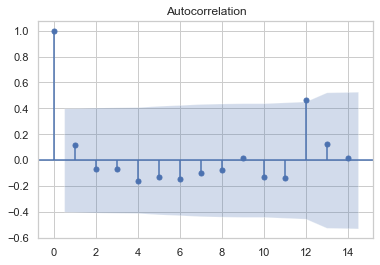

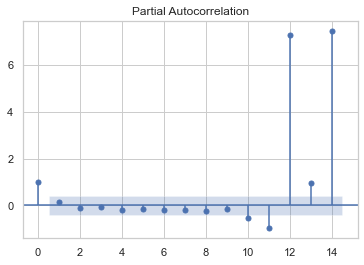

In [7]:
plot_acf(X)
plt.show()
print('\n')
plot_pacf(X)
plt.show()

## Modeling
### Grid Search, SARIMA

In [8]:
# Parameters Grid
pdq = []
PDQm = []

for i in range(6):
    for j in range(6):
        pdq.append((i,0,j))
        PDQm.append((i,0,j,12))

In [9]:
# Model fitting with param grid
models = []
for i in range(len(pdq)):
    try:
        sarima_fit = SARIMAX(train['Revenue'], order = pdq[i], seasonal_order = PDQm[i]).fit()
        models.append(sarima_fit)
    except:
        print('error {} {}'.format(pdq[i], PDQm[i]))

/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/neteplo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/ba

In [10]:
# RMSE & MAE calculation for all models
l_rmse = []
l_mae = []
l_quant_25 = []
l_quant_50 = []
l_quant_75 = []

for m in models:
    pred = m.predict(start='2018-01-01', end='2018-12-01')
    l_rmse.append((rmse(valid['Revenue'], pred))/10**6)
    l_mae.append((mae(valid['Revenue'], pred)/10**6))
    l_quant_25.append(np.array((quant(valid['Revenue'].values, pred, 0.25)/10**6)))
    l_quant_50.append(np.array((quant(valid['Revenue'].values, pred, 0.5)/10**6)))
    l_quant_75.append(np.array((quant(valid['Revenue'].values, pred, 0.75)/10**6)))

# DF with parameters and its metrics
sarima_df = pd.DataFrame({'pdq':pdq, 
                          'PDQm':PDQm, 
                          'RMSE':l_rmse, 
                          'MAE':l_mae, 
                          'QE25':l_quant_25,
                          'QE50':l_quant_50,
                          'QE75':l_quant_75,
                          'model':models})

In [11]:
# TOP 3 Best models
rmse_sarima_sort = sarima_df.sort_values('RMSE').head(3)
mae_sarima_sort = sarima_df.sort_values('MAE').head(3)
q25_sarima_sort = sarima_df.sort_values('QE25').head(3)
q50_sarima_sort = sarima_df.sort_values('QE50').head(3)
q75_sarima_sort = sarima_df.sort_values('QE75').head(3)
 
print('RMSE sorting', '\n', rmse_sarima_sort.drop('model', axis=1), '\n \n', 
      'MAE sorting', '\n', mae_sarima_sort.drop('model', axis=1), '\n \n',
      'Q25 error sorting', '\n', q25_sarima_sort.drop('model', axis=1), '\n \n',
      'Q50 error sorting', '\n', q50_sarima_sort.drop('model', axis=1), '\n \n',
      'Q75 error sorting', '\n', q75_sarima_sort.drop('model', axis=1))

best_models_idx = list(q75_sarima_sort.index)
best_models = [models[i] for i in best_models_idx]

RMSE sorting 
           pdq           PDQm      RMSE       MAE                 QE25  \
11  (1, 0, 5)  (1, 0, 5, 12)  1.540064  1.198688  0.11713066363964322   
17  (2, 0, 5)  (2, 0, 5, 12)  1.596601  0.957751  0.10643479088697846   
23  (3, 0, 5)  (3, 0, 5, 12)  2.481571  1.696073   0.3194005763910111   

                   QE50                 QE75  
11  0.07808710909309548  0.03904355454654774  
17  0.21286958177395693  0.31930437266093536  
23   0.6388011527820222   0.9582017291730334   
 
 MAE sorting 
           pdq           PDQm      RMSE       MAE                 QE25  \
17  (2, 0, 5)  (2, 0, 5, 12)  1.596601  0.957751  0.10643479088697846   
11  (1, 0, 5)  (1, 0, 5, 12)  1.540064  1.198688  0.11713066363964322   
23  (3, 0, 5)  (3, 0, 5, 12)  2.481571  1.696073   0.3194005763910111   

                   QE50                 QE75  
17  0.21286958177395693  0.31930437266093536  
11  0.07808710909309548  0.03904355454654774  
23   0.6388011527820222   0.9582017291730334   
 
 Q

In [21]:
rmse_sarima_sort[['pdq', 'PDQm', 'QE75', 'MAE']]

,pdq,PDQm,QE75,MAE
11,"(1, 0, 5)","(1, 0, 5, 12)",0.03904355454654774,1.198688
17,"(2, 0, 5)","(2, 0, 5, 12)",0.31930437266093536,0.957751
23,"(3, 0, 5)","(3, 0, 5, 12)",0.9582017291730334,1.696073


### SARIMA test

In [22]:
# Graph of predicted vs actual value (Validation/Test Sets)

def pred_graph(df, idx=0, loss = 'rmse', all_dates = False, savefig = False):
  
    """
    Return Graph of Given model prediction
    
    * df - Basis DataFrame contains Time Series to predict (valid/test)
    * loss - Which metric use for model selection (rmse, mae, Q25, Q50, Q75)
    * idx - index of model in best_model list (0, 1, 2 [in case of 3 best models])
    * all_dates - define wich dates range to display for actual data
        (False if only same dates range as model predict, True if all available date range)
    * savifig - False by default, if True - saving graph with 500 dpi
       
    """
    
    # Metric Selection
    if loss == 'rmse':
        best_models_idx = list(rmse_sarima_sort.index)
        best_models = [models[i] for i in best_models_idx]
    elif loss == 'mae':
        best_models_idx = list(mae_sarima_sort.index)
        best_models = [models[i] for i in best_models_idx]
    elif loss == 'Q25':
        best_models_idx = list(q25_sarima_sort.index)
        best_models = [models[i] for i in best_models_idx]
    elif loss == 'Q50':
        best_models_idx = list(q50_sarima_sort.index)
        best_models = [models[i] for i in best_models_idx]
    elif loss == 'Q75':
        best_models_idx = list(q75_sarima_sort.index)
        best_models = [models[i] for i in best_models_idx]   
    # Model selection
    model = best_models[idx]
    # Parameters Retrieving
    pdq = rmse_sarima_sort['pdq'].iloc[[idx]].values[0]
    PDQm = rmse_sarima_sort['PDQm'].iloc[[idx]].values[0]
    year = list(df['Date'])[0].year
    # Selecting right y_hat to predict based on given year
    y_pred = None
    y_true = df['Revenue'] 
    label_data = None
    # Legent labels behaviour 
    if year == 2018:
        y_pred = model.predict(start='2018-01-01', end='2018-12-01') 
        label_data = 'Validation Data'
    elif year == 2019:
        y_pred = model.predict(start='2019-01-01', end='2019-12-01') 
        label_data = 'Test Data'
    # Date range of actual data behaviour 
    if all_dates == True:
        plt.plot(data['Date'], data['Revenue'])
        plt.plot(df['Date'], y_pred, color='red')
    else:
        plt.plot(df['Date'], df['Revenue'])
        plt.plot(df['Date'], y_pred, color='red')
    # Legends, axis and so on
    b_patch = mpatches.Patch(color='C0', label=label_data)
    r_patch = mpatches.Patch(color='red', label='Prediction')
    plt.legend(handles=[b_patch, r_patch], loc='lower left')
    plt.xticks(rotation = 25)
    plt.ticklabel_format(axis = 'y', style = 'plain', useMathText=True)
    plt.title('SARIMA{}{} prediction for {} (loss: {})'.format(pdq, PDQm, year, loss))
    # Picture saving
    if savefig == True:
        plt.savefig('SARIMA{}{} prediction for {}.png'.format(pdq, PDQm, year), dpi=500)
    else:
        pass
    
    plt.show()
    # RMSE of predicted values & RMSE of naive model
    rmse_test = rmse(y_true, y_pred)
    naive_model_pred = sarima_df['model'][0].predict(start=df['Date'][0], end=df['Date'][-1])
    rmse_naive = rmse(y_true, naive_model_pred)
    # Tests results printing
    print('RMSE of SARIMA{}{} is {}'.format(pdq, PDQm, rmse_test))
    print('RMSE of naive model is {}'.format(rmse_naive))

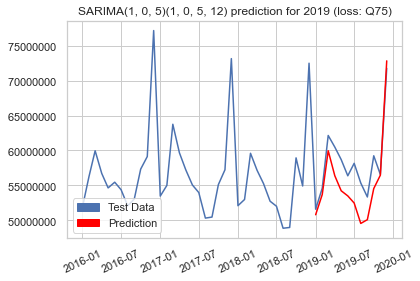

RMSE of SARIMA(1, 0, 5)(1, 0, 5, 12) is 3552700.999407008
RMSE of naive model is 58407751.03122976


In [25]:
pred_graph(test, loss = 'Q75', all_dates=True)

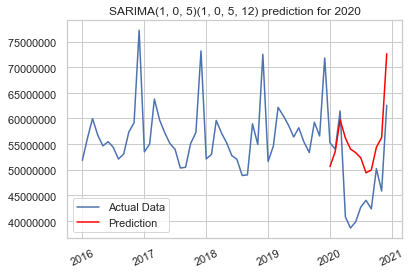

In [38]:
y_pred = models[11].predict(start='2020-01-01', end='2020-12-01')
plt.plot(excel['Revenue'].loc['2016':], label='Actual Data')
plt.plot(y_pred, color='red', label='Prediction')
plt.xticks(rotation = 25)
plt.ticklabel_format(axis = 'y', style = 'plain', useMathText=True)
plt.title('SARIMA(1, 0, 5)(1, 0, 5, 12) prediction for 2020')
plt.legend()
plt.savefig('SARIMA2020.png', dpi=500)

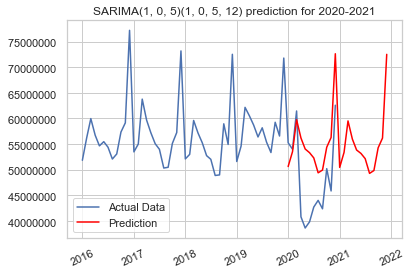

In [39]:
y_pred = models[11].predict(start='2020-01-01', end='2021-12-01')
plt.plot(excel['Revenue'].loc['2016':], label='Actual Data')
plt.plot(y_pred, color='red', label='Prediction')
plt.xticks(rotation = 25)
plt.ticklabel_format(axis = 'y', style = 'plain', useMathText=True)
plt.title('SARIMA(1, 0, 5)(1, 0, 5, 12) prediction for 2020-2021')
plt.legend()
plt.savefig('SARIMA2020-2021.png', dpi=500)

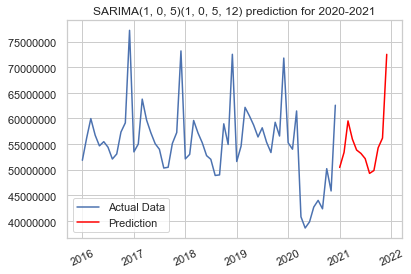

In [42]:
y_pred = models[11].predict(start='2021-01-01', end='2021-12-01')
plt.plot(excel['Revenue'].loc['2016':], label='Actual Data')
plt.plot(y_pred, color='red', label='Prediction')
plt.xticks(rotation = 25)
plt.ticklabel_format(axis = 'y', style = 'plain', useMathText=True)
plt.title('SARIMA(1, 0, 5)(1, 0, 5, 12) prediction for 2020-2021')
plt.legend()
plt.savefig('SARIMA2021.png', dpi=500)

q: 10588924.721305924


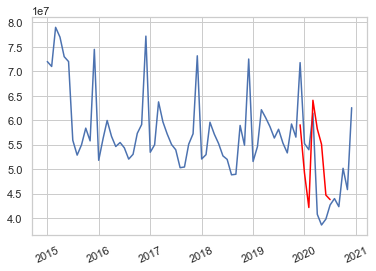

In [15]:
fr = models[29].forecast(31)
plt.plot(excel['Revenue'])
plt.plot(fr[23:], 'red')
plt.xticks(rotation = 25)
print('q:', rmse(excel['Revenue'][(excel['Date']>='2020') & (excel['Date']<='2020-07')], fr[24:]))
plt.show()

### Grid Search, ARIMA

In [ ]:
# Arima Models Grid Params
accept_lt = [] 
for ta in range(6): 
    for tm in range(6): 
        try: 
            model_tr = ARIMA(train['Revenue'], order = (ta,0,tm)) 
            results_tr = model_tr.fit() 
            accept_lt.append((ta,0,tm)) 
            print(f'accept {ta},{tm}') 
        except: 
            print(f'error {ta},{tm}')

In [ ]:
# RMSE, MAE df
l_rmse = []
l_mae = []

for i in accept_lt:
    arima_fit = ARIMA(train['Revenue'].values, order=i).fit()
    pred = arima_fit.predict(start=1, end=12)
    l_rmse.append((rmse(valid['Revenue'].values, pred))/10**6)
    l_mae.append((mae(valid['Revenue'].values, pred)/10**6))
    
df = pd.DataFrame({'params': accept_lt, 'RMSE': l_rmse, 'MAE':l_mae})

In [ ]:
mae_val_sorted = df.sort_values(by='MAE')
rmse_val_sorted = df.sort_values(by='RMSE')

model_to_test = list(rmse_val_sorted.head(3)['params'])

print(rmse_val_sorted.head(3))

### ARMA Test

In [ ]:
predictions = []

for i in model_to_test:
    arima_fit = ARIMA(train['Revenue'], order=i).fit()
    pred = arima_fit.predict(start=1, end=24)
    predictions.append(list(pred)[12:24])

In [ ]:
arma00 = ARIMA(train['Revenue'], order=(0,0,0)).fit()
predictions.append(list(arma00.predict(start=1, end=24))[12:24])

In [ ]:
y_pred = predictions[0]
y_true = test['Revenue']

fig = plt.figure()

ax = fig.add_subplot(sns.lineplot(x = "Date", y = "Revenue", data = test))
fig.add_subplot(sns.lineplot(x = test['Date'], y = y_pred, color='red'))

b_patch = mpatches.Patch(color='C0', label='Test Data')
r_patch = mpatches.Patch(color='red', label='Prediction')

plt.legend(handles=[b_patch, r_patch])
plt.xticks(rotation = 25)
plt.title('ARMA(0,1)')
fig.savefig('ARMA.png', dpi=500)
plt.show()

print(rmse(y_true, y_pred))